# Project: ReID

## Introduction

We wanted to reidentify a person, given some samples of the dataset. The idea is to learn the main features of the person in order to distinguish him/her from other people.



The first thing that we did was to import libraries.

In [22]:
from sklearn.svm import SVC
from sklearn.svm import SVR

from load_data import DataLoader
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import tqdm
import config
import math
import matplotlib.pyplot as plt
from utils import filter_and_split_dataset

The first thing that we did was to read the dataset and extract the information that we need in order to recognize people:

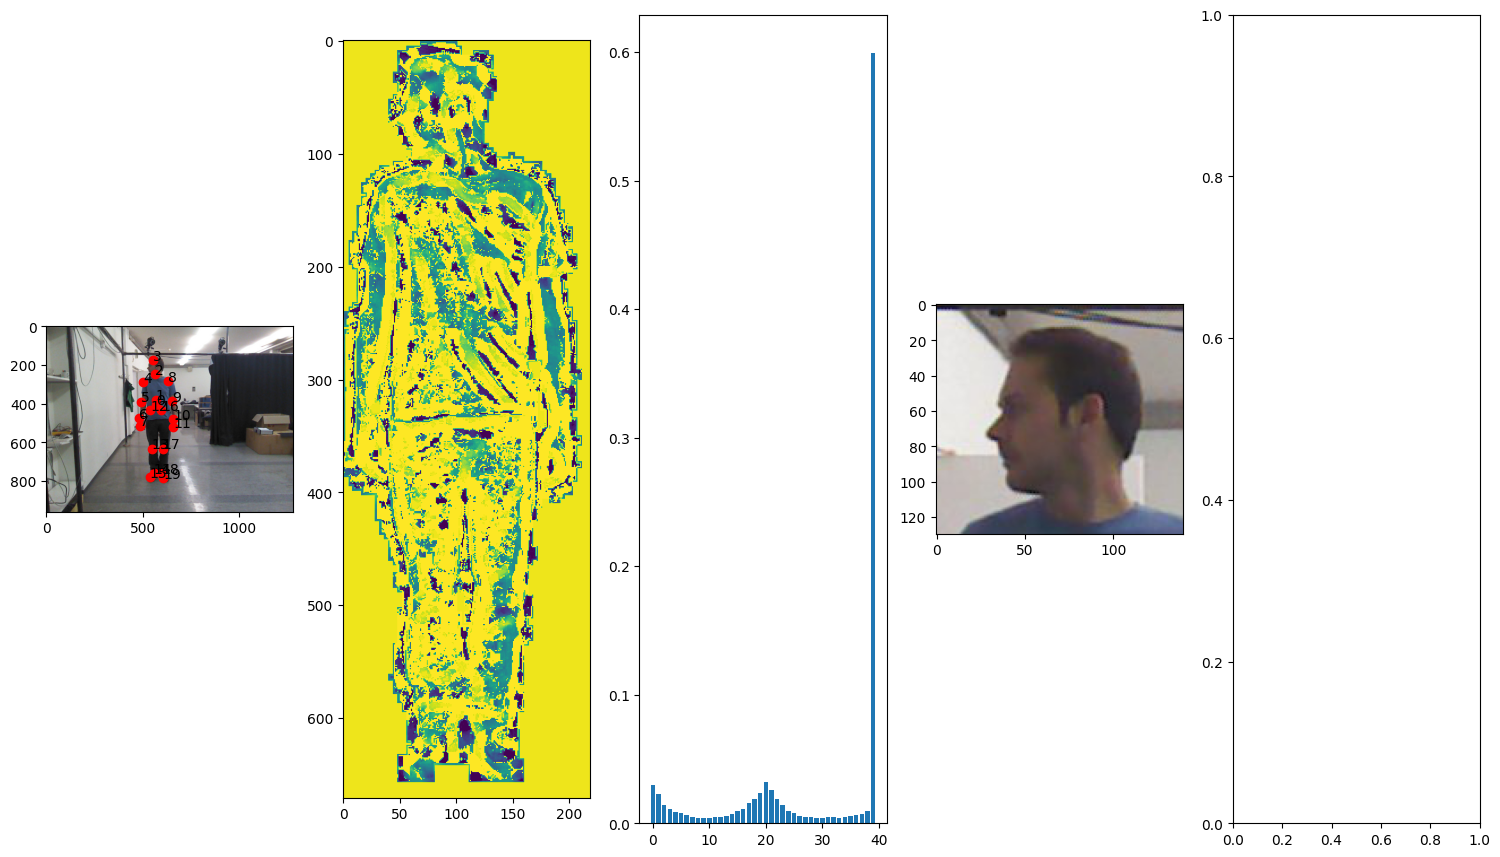

In [23]:
d = DataLoader()
d.read_dataset()
d.shuffle_videos()
d.display_dataset()

The next thing to do was to design the learning setting. The first and easiest idea was to test a variety of classifiers, and see which works better for our features.

We tested different classifiers:

In [24]:
def test_model(name, model_skel, model_clothes, model_face, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test):
    model_skel.fit(X_skel, y_train)
    model_clothes.fit(X_clothes, y_train)
    model_face.fit(X_face, y_face)


    print("-" * 10)
    print("|", name, "|")
    # Test
    print("-" * 10)
    skel_pred = model_skel.predict(X_skel_test)
    print(classification_report(y_test, skel_pred))
    print("-" * 10)
    clothes_pred = model_clothes.predict(X_clothes_test)
    print(classification_report(y_test, clothes_pred))
    print("-" * 10)
    face_pred = model_face.predict(X_face_test)
    print(classification_report(y_face_test, face_pred))

In [25]:
X = np.load(config.SAMPLED_PATH + "sample_0_X.npy")
y = np.load(config.SAMPLED_PATH + "sample_0_y.npy")
X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test = filter_and_split_dataset(X, y)


In [26]:
m1 = DecisionTreeClassifier()
m2 = DecisionTreeClassifier()
m3 = DecisionTreeClassifier()
test_model("DecisionTreeClassifier", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test)

----------
| DecisionTreeClassifier |
----------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       250
           1       0.70      0.54      0.61        13

    accuracy                           0.97       263
   macro avg       0.84      0.76      0.80       263
weighted avg       0.96      0.97      0.96       263

----------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       250
           1       0.67      0.62      0.64        13

    accuracy                           0.97       263
   macro avg       0.82      0.80      0.81       263
weighted avg       0.96      0.97      0.97       263

----------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        46
           1       0.00      0.00      0.00         0

    accuracy                           0.98        46
   macro avg       0.50      0.49      0.49        46
wei

/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
m1 = RandomForestClassifier()
m2 = RandomForestClassifier()
m3 = RandomForestClassifier()
test_model("RandomForestClassifier", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test)

----------
| RandomForestClassifier |
----------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       250
           1       0.90      0.69      0.78        13

    accuracy                           0.98       263
   macro avg       0.94      0.84      0.89       263
weighted avg       0.98      0.98      0.98       263

----------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       250
           1       0.71      0.38      0.50        13

    accuracy                           0.96       263
   macro avg       0.84      0.69      0.74       263
weighted avg       0.96      0.96      0.96       263

----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



In [28]:
m1 = KNeighborsClassifier()
m2 = KNeighborsClassifier()
m3 = KNeighborsClassifier()
test_model("KNeighborsClassifier", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test)

----------
| KNeighborsClassifier |
----------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       250
           1       0.82      0.69      0.75        13

    accuracy                           0.98       263
   macro avg       0.90      0.84      0.87       263
weighted avg       0.98      0.98      0.98       263

----------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       250
           1       0.64      0.69      0.67        13

    accuracy                           0.97       263
   macro avg       0.81      0.84      0.82       263
weighted avg       0.97      0.97      0.97       263

----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



In [29]:
m1 = LogisticRegression(solver="liblinear", max_iter=10000)
m2 = LogisticRegression(solver="liblinear", max_iter=10000)
m3 = LogisticRegression(solver="liblinear", max_iter=10000)
test_model("LogisticRegression", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test,  X_face_test, y_train, y_test, y_face, y_face_test)

----------
| LogisticRegression |
----------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       250
           1       0.00      0.00      0.00        13

    accuracy                           0.95       263
   macro avg       0.48      0.50      0.49       263
weighted avg       0.90      0.95      0.92       263

----------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       250
           1       0.00      0.00      0.00        13

    accuracy                           0.95       263
   macro avg       0.48      0.50      0.49       263
weighted avg       0.90      0.95      0.93       263

----------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        46
           1       0.00      0.00      0.00         0

    accuracy                           0.98        46
   macro avg       0.50      0.49      0.49        46
weighte

/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/si

In [30]:
m1 = GaussianNB()
m2 = GaussianNB()
m3 = GaussianNB()
test_model("GaussianNB", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test,  X_face_test, y_train, y_test, y_face, y_face_test)

----------
| GaussianNB |
----------
              precision    recall  f1-score   support

           0       0.97      0.90      0.94       250
           1       0.23      0.54      0.32        13

    accuracy                           0.89       263
   macro avg       0.60      0.72      0.63       263
weighted avg       0.94      0.89      0.91       263

----------
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       250
           1       0.26      0.69      0.37        13

    accuracy                           0.89       263
   macro avg       0.62      0.79      0.66       263
weighted avg       0.95      0.89      0.91       263

----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



In [31]:
m1 = SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42)
m2 = SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42)
m3 = SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42)
test_model("SVC", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test)

----------
| SVC |
----------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       250
           1       0.00      0.00      0.00        13

    accuracy                           0.95       263
   macro avg       0.48      0.50      0.49       263
weighted avg       0.90      0.95      0.93       263

----------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       250
           1       0.00      0.00      0.00        13

    accuracy                           0.95       263
   macro avg       0.48      0.50      0.49       263
weighted avg       0.90      0.95      0.93       263

----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/si